In [ ]:
# default_exp sampler.subset_sampler

# Subset Monte Carlo sampler

> Sampler class for subset Monte Carlo sampling

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.sampler.base_sampler import BaseSampler
from qsam.callbacks import CallbackList
from qsam.datatypes.counttree import Variable, Constant
from qsam.fault_generators import to_ndarray

import numpy as np
from tqdm.auto import tqdm # automatically choose jupyter tqdm version when available.

First, we need some helper functions for calculating possible weight vectors and subset occurences:

In [ ]:
#export
def circuit_subset_occurence(partitions, partition_w_vecs, p_phy_per_partition):
    """Return (weight)x(p_phys) subset occurance matrix"""
    n_partition_elems = np.array([len(p) for p in partitions])
    Aws = np.array([math.binom(w_vec, n_partition_elems, p_phy_per_partition) for w_vec in partition_w_vecs])
    Aws = np.product(Aws, axis=-1) # mult Aws for multi-parameter, i.e. multi-partitions
    return Aws

def protocol_subset_occurence(partition_dict, w_vecs_dict, p_phys):
    return {c_hash: circuit_subset_occurence(partition_dict[c_hash], w_vecs, p_phys)
            for c_hash, w_vecs in w_vecs_dict.items()}

Next, we introduce helper functions for subset filtering and selection:

In [ ]:
#export
def w_plus1_filter(sampler, w_ids, circuit_hash, **kwargs):
    n_Aws = np.ma.array(sampler.tree.constants[circuit_hash])#sampler.Aws_pmax[circuit_hash])
    n_Aws[w_ids,] = np.ma.masked # mask existing (already sampled) subsets
    w_ids.append(np.argmax(n_Aws)) # add next most important subset as possible candidate
    return w_ids

In [ ]:
#export
def random_sel(w_ids, **kwargs):
    return np.random.choice(w_ids), None

In [ ]:
#export
def ERV_sel(self, sampler, w_ids, circuit_hash, circuit, tree_node, **kwargs):

        
    _min_path_weight = sampler.tree.min_path_weight
    sampler.tree.min_path_weight = 0
    
    erv_deltas = np.ma.zeros(shape=len(w_ids))
    delta = sampler.tree.delta
    v_L = sampler.tree.variance
    
    for i, idx in enumerate(w_ids):
        
        w_vec = sampler.w_vecs[circuit_hash][idx]
        
        if circuit._ff_deterministic and not any(w_vec):
            erv_deltas[i] = np.ma.masked
            continue # exclude deterministic subsets from voting

        _tree_node = sampler.tree.add(w_vec, parent=tree_node, c_hash=circuit_hash, w_idx=idx, nodetype=Constant)
        # _twig = sampler.tree.twig(_tree_node)
        
        children = _tree_node.children
        if len(children) == 0: # subset doesn't exist.
            # delta_diff = _twig
            __tree_node_minus = sampler.tree.add(None, parent=_tree_node, nodetype=Variable)
            __tree_node_plus = sampler.tree.add('FAIL', parent=_tree_node, nodetype=Variable, marked=True)    
            
        elif len(children) == 1:
            # a = _tree_node.counts
            # c = children[0].counts
            # delta_diff = _twig * (a - c*sampler.tree.subtree(children[0], all_leaves=True)) / (a*(a+1))
            if children[0].marked:
                __tree_node_minus = sampler.tree.add(None, parent=_tree_node, nodetype=Variable)
                __tree_node_plus = children[0]
            else:
                __tree_node_minus = children[0]
                __tree_node_plus = sampler.tree.add('FAIL', parent=_tree_node, nodetype=Variable, marked=True)
                
        elif len(children) == 2:
            __tree_node_plus, __tree_node_minus = children 
            
            # delta_diff = _twig * sampler.tree.subtree(_tree_node, all_leaves=True) * ( ((__tree_node_minus.counts) / (_tree_node.counts + 1)) - __tree_node_minus.rate)


        else:
            raise Exception('Subset nodes cannot have >2 circuit nodes.')
            
        # v_L2 = sampler.tree.partial_variance(_tree_node)
        # v_L = sampler.tree.variance
        c = 1
        
        _tree_node.counts += c
 
        __tree_node_minus.counts += c
        _delta = sampler.tree.delta  # Dirty calc of delta! Always assumes No-fail to occur
        # v_L_minus2 = sampler.tree.partial_variance(_tree_node)
        v_L_minus = sampler.tree.variance
        __tree_node_minus.counts -= c

        __tree_node_plus.counts += c
        # v_L_plus2 = sampler.tree.partial_variance(_tree_node)
        v_L_plus = sampler.tree.variance
        __tree_node_plus.counts -= c
        
        _tree_node.counts -= c
            
        ## PARTIAL VAR AND PARTIAL DELTA FOR ERV NOT IDENTICAL!!!! -> CHECK
        
        
        _v_L = __tree_node_plus.rate * v_L_plus + __tree_node_minus.rate * v_L_minus
        # _v_L2 = __tree_node_plus.rate * v_L_plus2 + __tree_node_minus.rate * v_L_minus2
        
        # if _v_L != _v_L2: raise Exception('unequal v_L')
        # print(w_vec, "full var", v_L - _v_L)
        # print(w_vec, "part var", _twig**2*(v_L2 - _v_L2))

        # erv_delta = np.abs(_twig**2*(v_L - _v_L) + delta_diff)
        # erv_delta = np.abs(_twig**2*(v_L - _v_L) + _delta - delta)
        erv_delta = np.abs(v_L - _v_L + _delta - delta)
        # erv_delta = v_L - _v_L + _delta - delta
        # print(v_L, _v_L, )

        erv_deltas[i] = erv_delta
        
        if _tree_node.counts == 0: sampler.tree.detach(_tree_node)
        if __tree_node_plus.counts == 0: sampler.tree.detach(__tree_node_plus)
        if __tree_node_minus.counts == 0: sampler.tree.detach(__tree_node_minus)
        
    sampler.tree.min_path_weight = _min_path_weight
    idx = np.argmax(erv_deltas)
    erv = np.max(erv_deltas.filled(0))
    return w_ids[idx], erv

With these in place, we can define the SubsetSampler object:

In [ ]:
#export

class SubsetSampler(BaseSampler):
    
    def setup(self, p_max):
        p_max = to_ndarray(p_max)
        assert len(p_max) == len(self.fault_gen.partition_names)
        constants = protocol_subset_occurence(self.fault_gen.partitions, self.w_vecs, p_max)
        self.tree.constants = constants
        
    def stats(self, err_params=None):
        if err_params: self.fault_gen.__init__(err_params)
        Aws = protocol_subset_occurence(self.fault_gen.partitions, self.w_vecs, self.fault_gen.p_phy)
        Aws_pmax = self.tree.constants # backup constants
        self.tree.constants = Aws
        
        v_L = self.tree.variance
        p_L = self.tree.rate
        delta = self.tree.delta
        delta_var = self.tree.norm_variance
        
        self.tree.constants = Aws_pmax # reload constants
        
        if isinstance(v_L, np.ndarray) and isinstance(p_L, (int,float)):
            p_L = np.zeros_like(v_L)
        
        std = np.sqrt(v_L)
        p_L_up = p_L + delta
        std_up = np.sqrt( v_L + delta_var )
        
        return p_L, std, p_L_up, std_up
        
    def loop_fn(self, kwargs):
        circuit_hash = kwargs["circuit_hash"]
        tree_node = kwargs['tree_node']
        ss_sel_fn = kwargs['ss_sel_fn']
        ss_filter_fn = kwargs['ss_filter_fn']
        w_ids = [n.w_idx for n in tree_node.children]
        kwargs = kwargs | {"w_ids": w_ids}
        w_ids = ss_filter_fn(sampler=self, **kwargs)
        w_idx, erv = ss_sel_fn(sampler=self, **kwargs)
        w_vec = self.w_vecs[circuit_hash][w_idx]
        faults = self.fault_gen.faults_from_weights(w_vec, circuit_hash)
        return {'w_vec': w_vec, 'w_idx': w_idx, 'faults': faults, 'erv': erv}
        
    def run(self, n_samples, callbacks=[], ss_filter_fn=w_plus1_filter, ss_sel_fn=ERV_sel):
        
        if not isinstance(callbacks, CallbackList):
            callbacks = CallbackList(sampler=self, callbacks=callbacks)    
            
        self.stop_sampling = False
        callbacks.on_sampler_begin()
            
        for _ in tqdm(range(n_samples), desc="Total"):
            self.sample(callbacks, ss_filter_fn=ss_filter_fn, ss_sel_fn=ss_sel_fn)
            if self.stop_sampling: break
        
        callbacks.on_sampler_end()

In [ ]:
#slow
from qsam.examples.protocols import ghz_stab, ftsteane, ghz3

In [ ]:
# slow
from qsam.simulators.chp import ChpSimulator as CHP
from qsam.fault_generators import Depolarizing
import qsam.callbacks as cb

sample_range = np.logspace(-3,0,5)
err_params = {'p': sample_range}

fault_gen = Depolarizing(err_params)
sam = SubsetSampler(ghz3, CHP, fault_gen, p_max=0.05)

callbacks = [
    # cb.StatsPerSample(),
    # cb.ErvPerSample(),
    # cb.PlotStats()
]
sam.run(300, callbacks=callbacks)

sam.tree.draw()
# print(sam.tree)


Total:   0%|          | 0/300 [00:00<?, ?it/s]

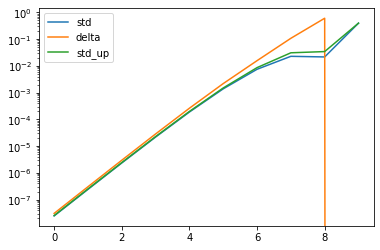

In [ ]:
import matplotlib.pyplot as plt

stats = sam.stats()
plt.plot(stats[1], label='std')
plt.plot(stats[2], label='delta')
plt.plot(stats[3], label='std_up')
plt.yscale('log')
plt.legend()